# GSE153480 - preprocessing
## Xiaonan Wang
## 05Jun2022

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


# Data in

In [2]:
FileDir = '/nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE153480/'

In [8]:
meta = pd.DataFrame([['GSM4644949', '1', 'neonatal', 'MI', '1', 'ICR/CD1', 'ventricle'],
                     ['GSM4644950', '1', 'neonatal', 'Sham', '1', 'ICR/CD1', 'ventricle'],
                     ['GSM4644951', '1', 'neonatal', 'MI', '3', 'ICR/CD1', 'ventricle'],
                     ['GSM4644952', '1', 'neonatal', 'Sham', '3', 'ICR/CD1', 'ventricle'],
                     ['GSM4644953', '8', 'adult', 'MI', '1', 'ICR/CD1', 'ventricle'],
                     ['GSM4644954', '8', 'adult', 'Sham', '1', 'ICR/CD1', 'ventricle'],
                     ['GSM4644955', '8', 'adult', 'MI', '3', 'ICR/CD1', 'ventricle'],
                     ['GSM4644956', '8', 'adult', 'Sham', '3', 'ICR/CD1', 'ventricle']
                    ], columns = ['Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue'])

In [ ]:
Files = [x for x in listdir(FileDir) if 'matrix' in x]
print(Files)

In [17]:
adata = []
for idx, row in meta.iterrows():
    FN = [x for x in Files if row['Index'] in x][0]
    adata_sub = sc.read_10x_mtx(FileDir, prefix=FN[:-10], cache=True)
    adata_sub.obs['Index'] = row['Index']
    adata_sub.obs['Day'] = row['Day']
    adata_sub.obs['Condition'] = row['Condition']
    adata_sub.obs['Genotype'] = 'WT'
    adata_sub.obs['CellType'] = 'ventricle tissue'
    adata_sub.obs['Organism'] = 'Mus musculus'
    adata_sub.obs['Strain'] = row['Strain']
    adata_sub.obs['Development_stage'] = row['Development_stage']
    adata_sub.obs['Tissue'] = row['Tissue']
    adata_sub.obs['Age'] = row['Age']
    adata_sub.obs['StudyID'] = row['Index']
    adata_sub.obs['Tissue'] = row['Tissue']
    adata_sub.var_names_make_unique()
    adata.append(adata_sub)
    del adata_sub

... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-GSE153480-GSM4644949_P1_1MI_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-GSE153480-GSM4644950_P1_1Sham_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-GSE153480-GSM4644951_P1_3MI_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-GSE153480-GSM4644952_P1_3Sham_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-GSE153480-GSM4644953_P8_1MI_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-GSE153480-GSM4644954_P8_1Sham_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-GSE153480-GSM4644955_P8_3MI_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-GSE153480-GSM4644956_P8_3Sham_matrix.h5ad


# Doublet removal

In [10]:
import scrublet as scr

In [18]:
scrub_obj = []
for i in range(len(adata)):
    scrub = scr.Scrublet(adata[i].X.toarray())
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata[i].obs['db_scores'] = doublet_scores
    adata[i].obs['predicted_db'] = predicted_doublets
    scrub_obj.append(scrub)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 24.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.8%
Elapsed time: 2.3 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 29.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.5%
Elapsed time: 3.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 29.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 3.6 seconds
Preprocessing...
Simulating double

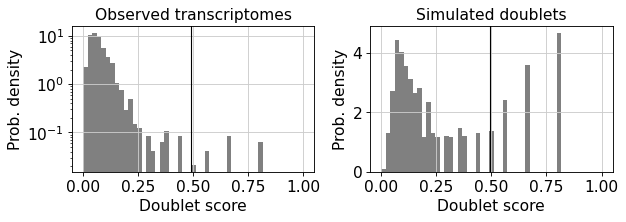

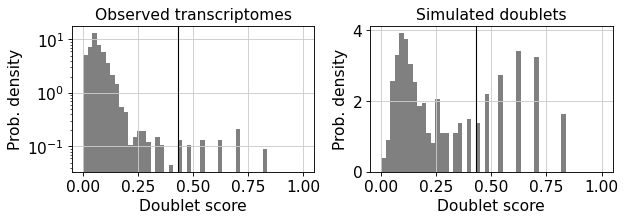

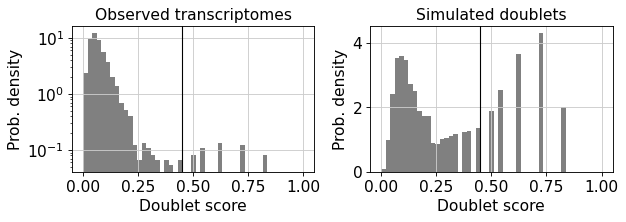

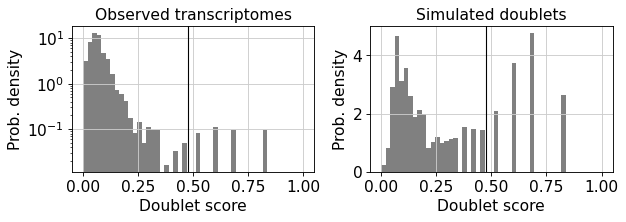

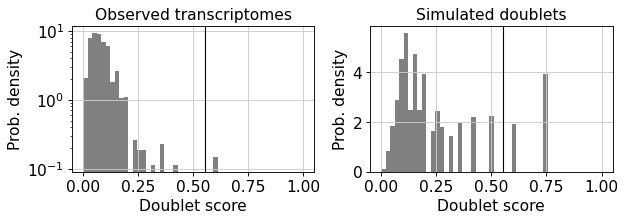

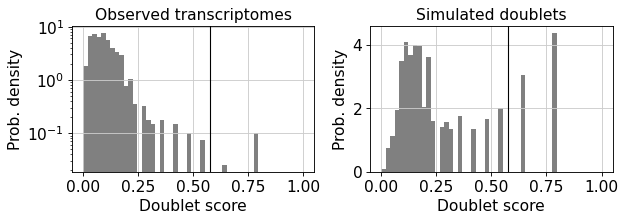

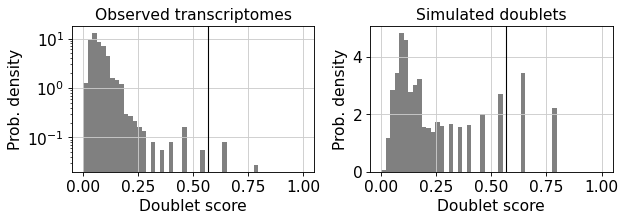

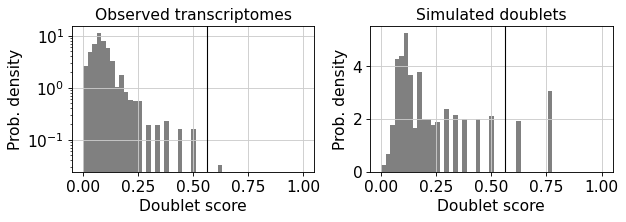

In [19]:
for i in range(len(adata)):
    scrub_obj[i].plot_histogram()

In [13]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

24
['MI: Number of doublets = 10']
139
['Sham: Number of doublets = 54']
64
['MI: Number of doublets = 39']
93
['Sham: Number of doublets = 24']
16
['MI: Number of doublets = 4']
31
['Sham: Number of doublets = 5']
20
['MI: Number of doublets = 4']
24
['Sham: Number of doublets = 1']


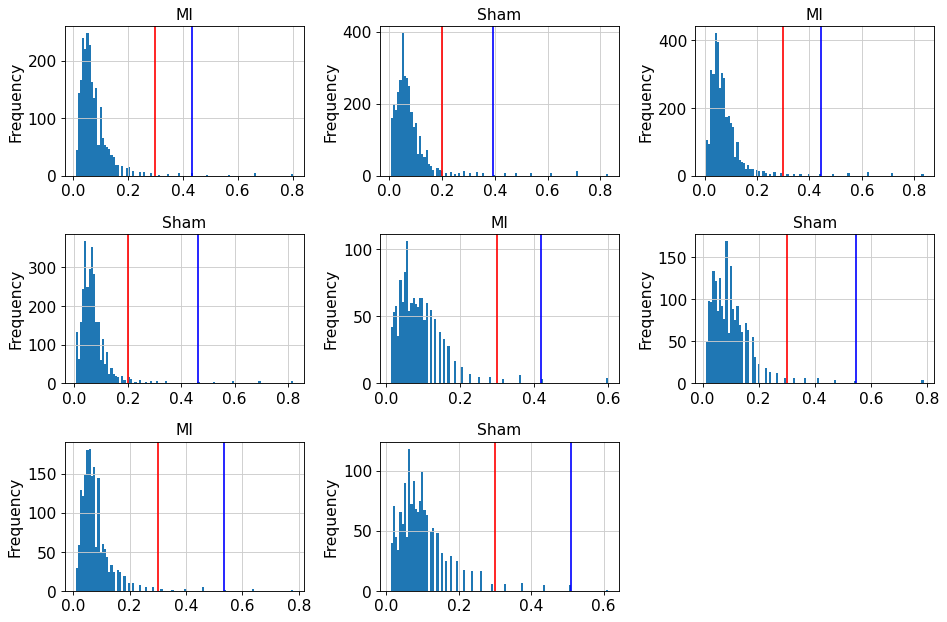

In [22]:
cutoffs = [0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3]

fig, ax = plt.subplots(3,3, figsize=(12,8))
ax = ax.flatten()
ax = trim_axs(ax, len(adata))
for i in range(len(adata)):    
    pd.DataFrame(adata[i].obs['db_scores']).plot.hist(bins=100, ax=ax[i])
    ax[i].axvline(x=cutoffs[i], color='r')
    ax[i].axvline(x=np.sort(adata[i].obs['db_scores'])[::-1][np.sum(adata[i].obs['predicted_db'])], color='b')
    ax[i].get_legend().remove()
    ax[i].set_title(adata[i].obs['Condition'][0])
    print(np.sum(adata[i].obs['db_scores'] > cutoffs[i]))
    print(np.unique(adata[i].obs['Condition'])+': Number of doublets = '+str(np.sum(adata[i].obs['predicted_db'])))
plt.tight_layout()  

In [23]:
for i in range(len(adata)):
    adata[i].obs['predicted_db'] = adata[i].obs['db_scores'] > cutoffs[i]

In [24]:
# remove doublets
for i in range(len(adata)):
    print(np.unique(adata[i].obs['Condition'])+str(adata[i].shape))
    adata[i] = adata[i][~adata[i].obs['predicted_db'],:].copy()
    print(np.unique(adata[i].obs['Condition'])+str(adata[i].shape))

['MI(2332, 28692)']
['MI(2308, 28692)']
['Sham(3297, 28692)']
['Sham(3158, 28692)']
['MI(3651, 28692)']
['MI(3587, 28692)']
['Sham(3023, 28692)']
['Sham(2930, 28692)']
['MI(1308, 27998)']
['MI(1292, 27998)']
['Sham(1961, 28692)']
['Sham(1930, 28692)']
['MI(1782, 28692)']
['MI(1762, 28692)']
['Sham(1508, 28692)']
['Sham(1484, 28692)']


# QC

In [25]:
[x for x in adata[0].var_names if 'mt-' in x]

['mt-Nd1',
 'mt-Nd2',
 'mt-Co1',
 'mt-Co2',
 'mt-Atp8',
 'mt-Atp6',
 'mt-Co3',
 'mt-Nd3',
 'mt-Nd4l',
 'mt-Nd4',
 'mt-Nd5',
 'mt-Nd6',
 'mt-Cytb']

In [26]:
for i in range(len(adata)):
    adata[i].var['mt'] = adata[i].var_names.str.startswith('mt-') 
    sc.pp.calculate_qc_metrics(adata[i], qc_vars=['mt'], inplace=True)

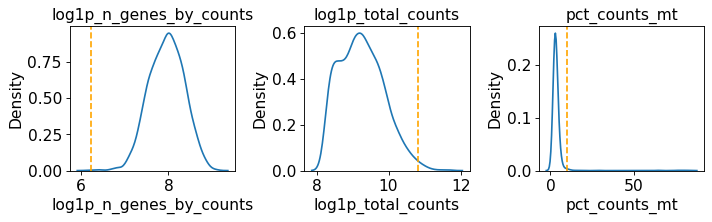

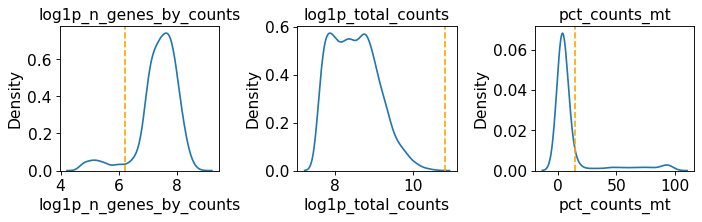

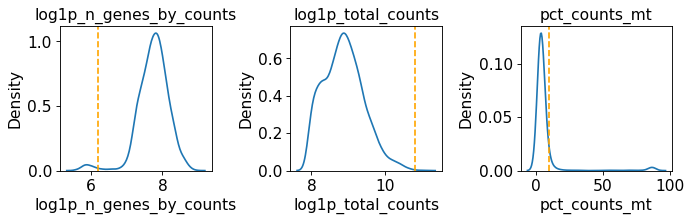

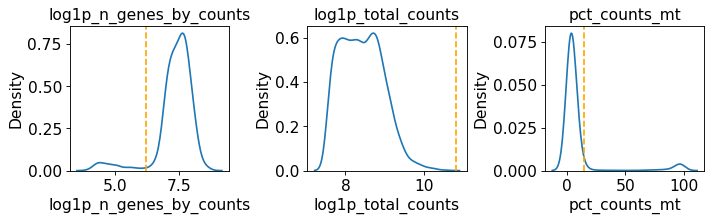

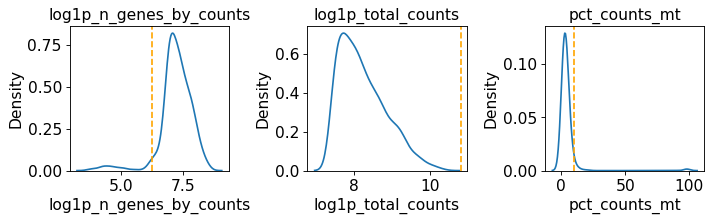

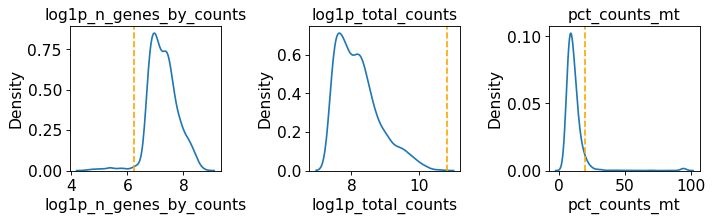

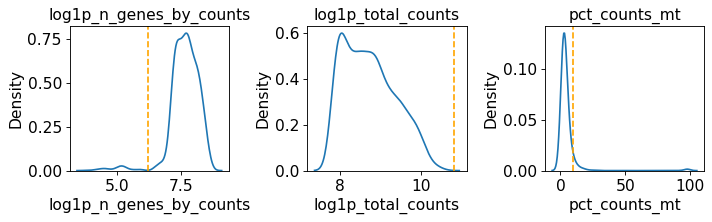

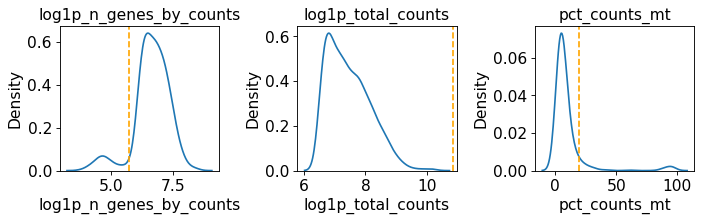

In [29]:
cutoffs = [[500,50000, np.exp(10)],
           [500,50000, np.exp(15)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(15)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(20)],
           [500,50000, np.exp(10)],
           [300,50000, np.exp(20)]]
for i in range(len(adata)):
    obs_terms = ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt']
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    for j in range(len(obs_terms)):
        sns.kdeplot(adata[i].obs[obs_terms[j]], ax=ax[j])
        ax[j].grid(False)
        ax[j].set_title(obs_terms[j])
        ax[j].axvline(np.log1p(cutoffs[i][j]), c='orange', linestyle='--')
    plt.tight_layout()

In [30]:
for i in range(len(adata)):
    sc.pp.filter_cells(adata[i], min_genes=cutoffs[i][0])
    #sc.pp.filter_genes(adata[i], min_cells=1)
    adata[i] = adata[i][(adata[i].obs['total_counts'] <= cutoffs[i][1]) & (adata[i].obs['pct_counts_mt'] <= np.log(cutoffs[i][2])), :].copy()
    print(adata[i].obs['Condition'].value_counts().sort_index())

filtered out 1 cells that have less than 500 genes expressed
filtered out 213 cells that have less than 500 genes expressed


MI    2252
Name: Condition, dtype: int64
Sham    2649
Name: Condition, dtype: int64


filtered out 70 cells that have less than 500 genes expressed
filtered out 183 cells that have less than 500 genes expressed
filtered out 58 cells that have less than 500 genes expressed
filtered out 37 cells that have less than 500 genes expressed


MI    3359
Name: Condition, dtype: int64
Sham    2702
Name: Condition, dtype: int64
MI    1203
Name: Condition, dtype: int64


filtered out 42 cells that have less than 500 genes expressed
filtered out 111 cells that have less than 300 genes expressed


Sham    1816
Name: Condition, dtype: int64
MI    1633
Name: Condition, dtype: int64
Sham    1305
Name: Condition, dtype: int64


In [31]:
for i in range(len(adata)):
    print(adata[i].shape)

(2252, 28692)
(2649, 28692)
(3359, 28692)
(2702, 28692)
(1203, 27998)
(1816, 28692)
(1633, 28692)
(1305, 28692)


In [32]:
#combine and save the raw counts
adata1 = anndata.AnnData.concatenate(*adata)

In [33]:
adata1.shape

(16919, 27998)

In [34]:
sc.pp.filter_genes(adata1, min_cells=1)

filtered out 5959 genes that are detected in less than 1 cells


In [36]:
adata1.write('./write/GSE153480_raw.h5ad')

# Normalisation

In [37]:
adata = sc.read('./write/GSE153480_raw.h5ad')

In [38]:
print(adata.shape)

(16919, 22039)


In [39]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [40]:
# log counts
sc.pp.log1p(adata)

In [41]:
adata.raw = adata

In [42]:
print(adata.shape)

(16919, 22039)


In [43]:
adata.write('./write/GSE153480_lognorm.h5ad')

# Cell Cycle Assignment

In [44]:
adata = sc.read('./write/GSE153480_lognorm.h5ad')

In [45]:
print(adata.shape)

(16919, 22039)


In [46]:
cell_cycle_genes = [x.strip()[0].upper()+x.strip()[1:].lower() for x in open('/nfs01data1/Groups/Wangxiaonan/Lab_members/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [47]:
np.setdiff1d(cell_cycle_genes, adata.raw.var_names)

array(['Mlf1ip'], dtype='<U8')

In [48]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 97


In [50]:
ERR = adata.obs['Index'].cat.categories
print(ERR)

Index(['GSM4644949', 'GSM4644950', 'GSM4644951', 'GSM4644952', 'GSM4644953',
       'GSM4644954', 'GSM4644955', 'GSM4644956'],
      dtype='object')


In [51]:
phase = []
for i in range(len(ERR)):
    adata_sub = adata[adata.obs['Index'] == ERR[i]].copy()
    print(adata_sub.shape)
    sc.pp.scale(adata_sub)
    sc.tl.score_genes_cell_cycle(adata_sub, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)
    phase.append(adata_sub.obs[['phase', 'S_score', 'G2M_score']])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2252, 22039)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    686 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    766 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2649, 22039)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    858 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    858 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(3359, 22039)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    730 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    814 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2702, 22039)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    769 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    817 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'


(1203, 22039)


    finished: added
    'S_score', score of gene set (adata.obs).
    776 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    773 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1816, 22039)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    771 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    737 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1633, 22039)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    813 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    813 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1305, 22039)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    771 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    686 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [52]:
phase_pd = pd.concat(phase)

In [53]:
phase_pd.head()

,phase,S_score,G2M_score
AAACCTGAGAATTGTG-1-0,S,1.264236,0.602823
AAACCTGAGACTACAA-1-0,S,0.105437,-0.418419
AAACCTGGTCCGTGAC-1-0,S,0.438366,-0.339203
AAACCTGGTTAAAGTG-1-0,G1,-0.250754,-0.106459
AAACGGGAGTGAAGTT-1-0,G2M,-0.460345,0.044235


In [54]:
print(phase_pd.shape)

(16919, 3)


In [55]:
phase_pd.to_csv('cell_cycle_results.txt')

# Select highly variable genes

In [56]:
adata = sc.read('./write/GSE153480_lognorm.h5ad')

In [57]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [58]:
adata.obs.head(3)

,Index,Day,Condition,Genotype,CellType,Organism,Strain,Development_stage,Tissue,Age,...,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,batch,n_counts,phase,S_score,G2M_score
AAACCTGAGAATTGTG-1-0,GSM4644949,1,MI,WT,ventricle tissue,Mus musculus,ICR/CD1,neonatal,ventricle,1,...,65.574135,1043.0,6.950815,2.901978,5460,0,35939.0,S,1.264236,0.602823
AAACCTGAGACTACAA-1-0,GSM4644949,1,MI,WT,ventricle tissue,Mus musculus,ICR/CD1,neonatal,ventricle,1,...,62.731259,448.0,6.107023,3.069755,3772,0,14594.0,S,0.105437,-0.418419
AAACCTGGTCCGTGAC-1-0,GSM4644949,1,MI,WT,ventricle tissue,Mus musculus,ICR/CD1,neonatal,ventricle,1,...,63.556086,268.0,5.594711,3.198091,2772,0,8379.0,S,0.438366,-0.339203


In [59]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes
... storing 'phase' as categorical
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


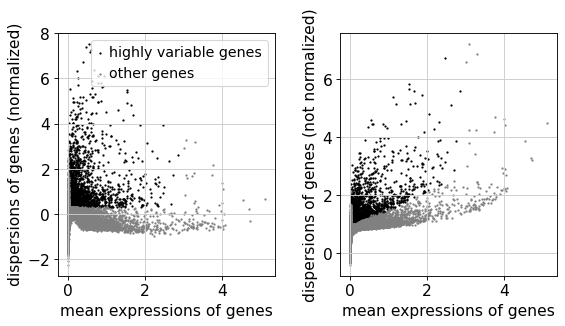

In [60]:
sc.pl.highly_variable_genes(adata)

In [61]:
print(np.sum(adata.var.highly_variable))

3080


In [62]:
adata = adata[:, adata.var.highly_variable].copy()

In [63]:
adata.write('./write/GSE153480_lognorm_hvg.h5ad')

# Preliminary processing

In [64]:
adata = sc.read('./write/GSE153480_lognorm_hvg.h5ad')

In [65]:
# normally regress out the top layers of unwanted effects
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:52)


In [66]:
# scale for pca
sc.pp.scale(adata)
# pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


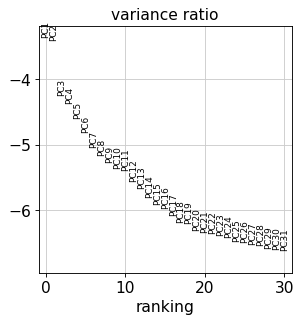

In [67]:
sc.pl.pca_variance_ratio(adata, log=True)

In [68]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [69]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


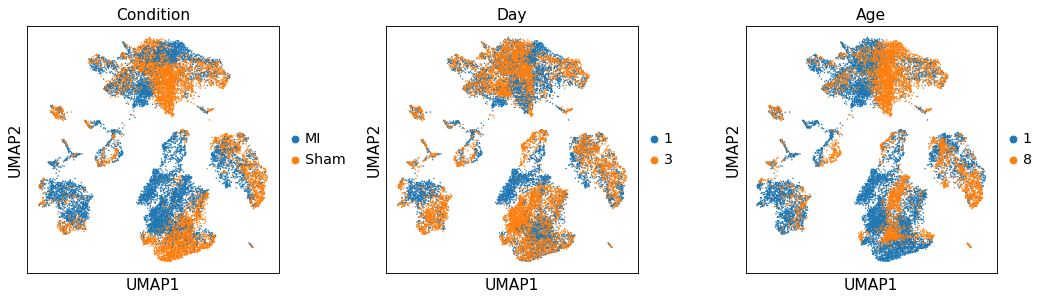

In [70]:
sc.pl.umap(adata, color= ['Condition', 'Day', 'Age'], wspace=0.3)

In [71]:
adata.write('./write/GSE153480_processed.h5ad')

#  Further modify

In [72]:
adata = sc.read('./write/GSE153480_processed.h5ad')

In [73]:
adata.obs['Day'].value_counts()

3    8999
1    7920
Name: Day, dtype: int64

In [74]:
adata.obs['Day'] = adata.obs['Day'].astype(int)

In [75]:
adata.obs['Age'].value_counts()

1    10962
8     5957
Name: Age, dtype: int64

In [76]:
adata.obs['Age'] = adata.obs['Age'].astype(int)

In [77]:
adata.obs['Development_stage'].value_counts()

neonatal    10962
adult        5957
Name: Development_stage, dtype: int64

In [78]:
adata.obs['Genotype'].value_counts()

WT    16919
Name: Genotype, dtype: int64

In [79]:
adata.obs['CellType'].value_counts()

ventricle tissue    16919
Name: CellType, dtype: int64

In [83]:
adata.obs['CellType'] = 'Cardiac cells'

In [84]:
adata.obs['CellType'].value_counts()

Cardiac cells    16919
Name: CellType, dtype: int64

In [82]:
adata.obs['Tissue'].value_counts()

ventricle    16919
Name: Tissue, dtype: int64

In [85]:
adata.obs['StudyID'].value_counts()

GSM4644951    3359
GSM4644952    2702
GSM4644950    2649
GSM4644949    2252
GSM4644954    1816
GSM4644955    1633
GSM4644956    1305
GSM4644953    1203
Name: StudyID, dtype: int64

In [87]:
adata.obs['StudyID'] = 'GSE153480'

In [88]:
adata.obs['StudyID'].value_counts()

GSE153480    16919
Name: StudyID, dtype: int64

In [86]:
adata.obs['Index'].value_counts()

GSM4644951    3359
GSM4644952    2702
GSM4644950    2649
GSM4644949    2252
GSM4644954    1816
GSM4644955    1633
GSM4644956    1305
GSM4644953    1203
Name: Index, dtype: int64

In [89]:
adata.obs['Condition'].value_counts()

Sham    8472
MI      8447
Name: Condition, dtype: int64

In [90]:
adata.write('./write/GSE153480_processed.h5ad')

... storing 'CellType' as categorical
... storing 'StudyID' as categorical
